In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [5]:
# Selected features 
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']


# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Host Response Rate,Accommodates,Bathrooms,Bedrooms,Beds,...,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,x,y,z,text_encoding_tsne_1,text_encoding_tsne_2
27357,3,4,2.45,1,23,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208824,-0.728089,0.652900,-7.517027,-0.076676
17998,1,35,2.75,10,156,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208893,-0.728482,0.652440,-7.517027,-0.076676
11703,3,16,0.62,4,37,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209660,-0.728891,0.651737,-7.517027,-0.076676
25026,1,0,0.00,10,284,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208956,-0.727793,0.653188,-7.517027,-0.076676
31283,1,0,0.00,1,43,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209579,-0.728689,0.651989,-7.517027,-0.076676


# Random Forest

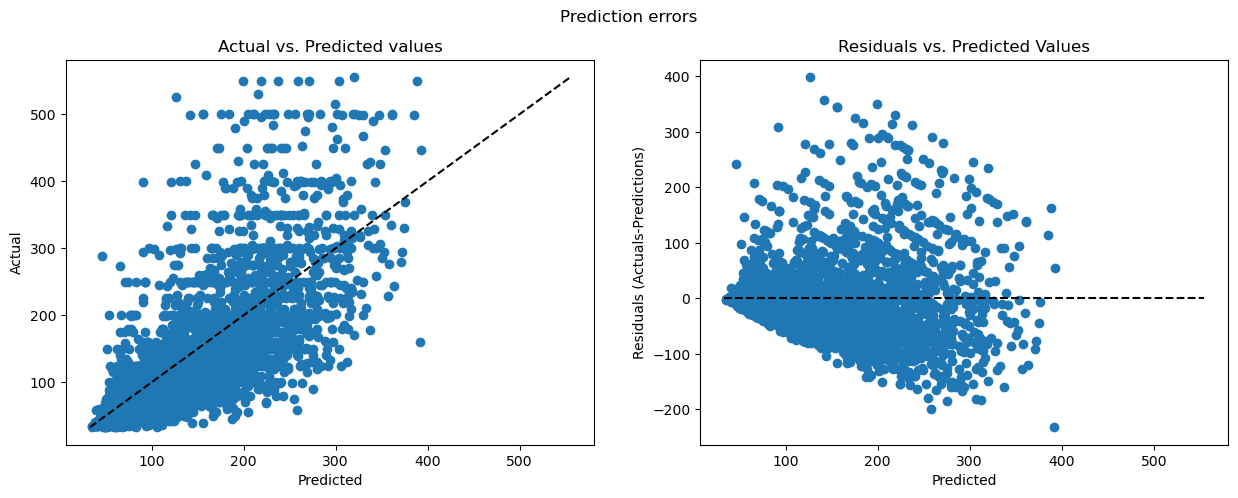

R²: 0.5439584366219168
MAE: 42.0441995947315
MSE: 4079.8674609568325
RMSE: 63.873840192655024
MAPE: 0.33204122479216275
error_ratio_rmse: 0.4618182443375751
error_ratio_mae: 0.30398639541403777


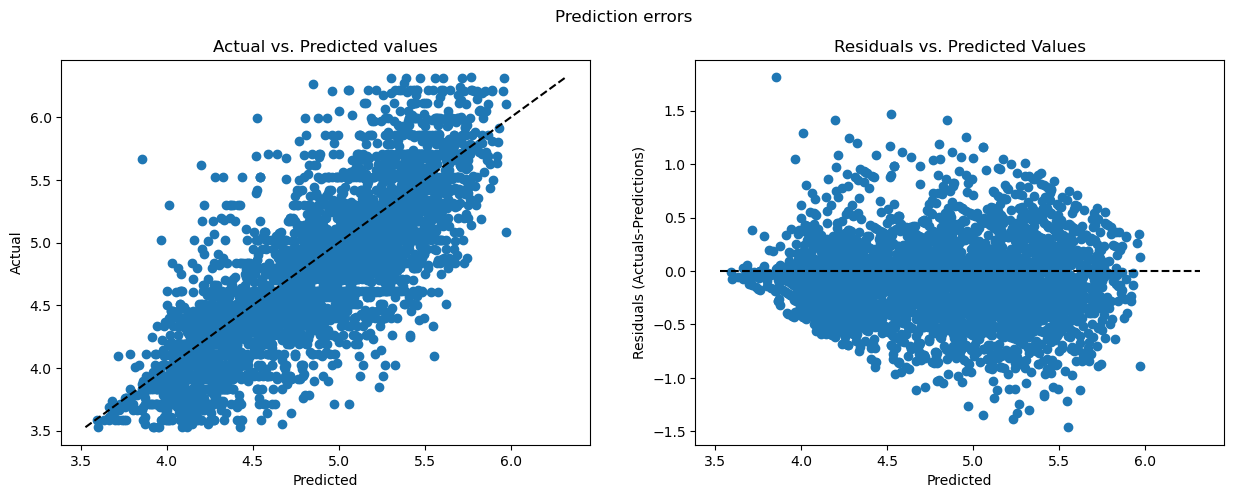

R²: 0.6327080393977993
MAE: 0.29076903123470377
MSE: 0.1427408133272699
RMSE: 0.37781055216506315
MAPE: 0.06263058441574891
error_ratio_rmse: 0.07973837340511179
error_ratio_mae: 0.06136792488820122


In [7]:
model_init = RandomForestRegressor(criterion = "squared_error").fit(X_train_np, y_train_np)
y_pred = np.maximum(0,model_init.predict(X_test_np))

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [8]:
space={       
        'n_estimators':hp.quniform('n_estimators',10,500,1),
        'max_depth':hp.quniform('max_depth',5,20,1),
        'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
        'min_samples_split':hp.quniform('min_samples_split',2,6,1),
        'max_features':hp.uniform('max_features',0.0,1.0),
        'min_impurity_decrease':hp.uniform('min_impurity_decrease',0.0001,0.2), 
        'random_state': hp.quniform('random_state',0,400,1)
    }

def objective(space):
    mod=RandomForestRegressor(
                          n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          min_samples_leaf = int(space['min_samples_leaf']),
                          min_samples_split = int(space['min_samples_split']),
                          max_features=space['max_features'],
                          min_impurity_decrease=space['min_impurity_decrease'],
                          random_state = int(space['random_state']),
                          criterion = 'squared_error',
                          oob_score = True
                       )
    
    mod.fit(X_train_np, y_train_np)

    y_pred = mod.predict(X_test_np)
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

R²: 0.46829065645589374                                                                                                
MAE: 46.52074227305283                                                                                                 
MSE: 4756.811272515191                                                                                                 
RMSE: 68.9696402231822                                                                                                 
MAPE: 0.3969235717777085                                                                                               
error_ratio_rmse: 0.4986617066453891                                                                                   
error_ratio_mae: 0.3363525264337023                                                                                    
SCORE:                                                                                                                 
68.9696402231822                        

C:\Users\adelr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



R²: 0.5610452915878883                                                                                                 
MAE: 41.09664871873179                                                                                                 
MSE: 3927.0039739768968                                                                                                
RMSE: 62.66581184327621                                                                                                
MAPE: 0.3218412173860327                                                                                               
error_ratio_rmse: 0.45308400306231367                                                                                  
error_ratio_mae: 0.29713544859989843                                                                                   
SCORE:                                                                                                                 
62.66581184327621                       

C:\Users\adelr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



error_ratio_mae: 0.3042778710387291                                                                                    
SCORE:                                                                                                                 
63.9713682412745                                                                                                       
R²: 0.5376786915760924                                                                                                 
MAE: 42.34482035545823                                                                                                 
MSE: 4136.047707524234                                                                                                 
RMSE: 64.31211167054177                                                                                                
MAPE: 0.3326891365551191                                                                                               
error_ratio_rmse: 0.4649870183434969    

SCORE:                                                                                                                 
62.826967833769274                                                                                                     
R²: 0.5273904856616771                                                                                                 
MAE: 42.93779884482958                                                                                                 
MSE: 4228.088696575592                                                                                                 
RMSE: 65.02375486370802                                                                                                
MAPE: 0.3419093812105729                                                                                               
error_ratio_rmse: 0.4701323142748447                                                                                   
error_ratio_mae: 0.31044726320556165    

62.83412499660468                                                                                                      
R²: 0.5601908263918571                                                                                                 
MAE: 41.14529499456264                                                                                                 
MSE: 3934.6482437754303                                                                                                
RMSE: 62.72677453667955                                                                                                
MAPE: 0.3219005206349366                                                                                               
error_ratio_rmse: 0.4535247732422919                                                                                   
error_ratio_mae: 0.29748716907936235                                                                                   
SCORE:                                  

R²: 0.5357014466128462                                                                                                 
MAE: 42.58616223640835                                                                                                 
MSE: 4153.736659663014                                                                                                 
RMSE: 64.44948921180846                                                                                                
MAPE: 0.3424364340660904                                                                                               
error_ratio_rmse: 0.4659802802912339                                                                                   
error_ratio_mae: 0.30790487338437494                                                                                   
SCORE:                                                                                                                 
64.44948921180846                       

C:\Users\adelr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



R²: 0.5595368454653489                                                                                                 
MAE: 41.136862211037496                                                                                                
MSE: 3940.4989287050744                                                                                                
RMSE: 62.77339347769144                                                                                                
MAPE: 0.3226387117100512                                                                                               
error_ratio_rmse: 0.45386183576156514                                                                                  
error_ratio_mae: 0.2974261986841158                                                                                    
SCORE:                                                                                                                 
62.77339347769144                       

MAE: 41.54146465053195                                                                                                 
MSE: 4000.170770910313                                                                                                 
RMSE: 63.246903251545156                                                                                               
MAPE: 0.3266984221505489                                                                                               
error_ratio_rmse: 0.45728538837368676                                                                                  
error_ratio_mae: 0.30035154007111314                                                                                   
SCORE:                                                                                                                 
63.246903251545156                                                                                                     
R²: 0.555731557135556                   

In [9]:
best_hyperparams = {'max_depth': 18.0,
                     'max_features': 0.47276257775853475,
                     'min_impurity_decrease': 0.19592205140419866,
                     'min_samples_leaf': 3.0,
                     'min_samples_split': 2.0,
                     'n_estimators': 411.0,
                     'random_state': 0.0}

{'max_depth': 18.0,
 'max_features': 0.47276257775853475,
 'min_impurity_decrease': 0.19592205140419866,
 'min_samples_leaf': 3.0,
 'min_samples_split': 2.0,
 'n_estimators': 411.0,
 'random_state': 0.0}

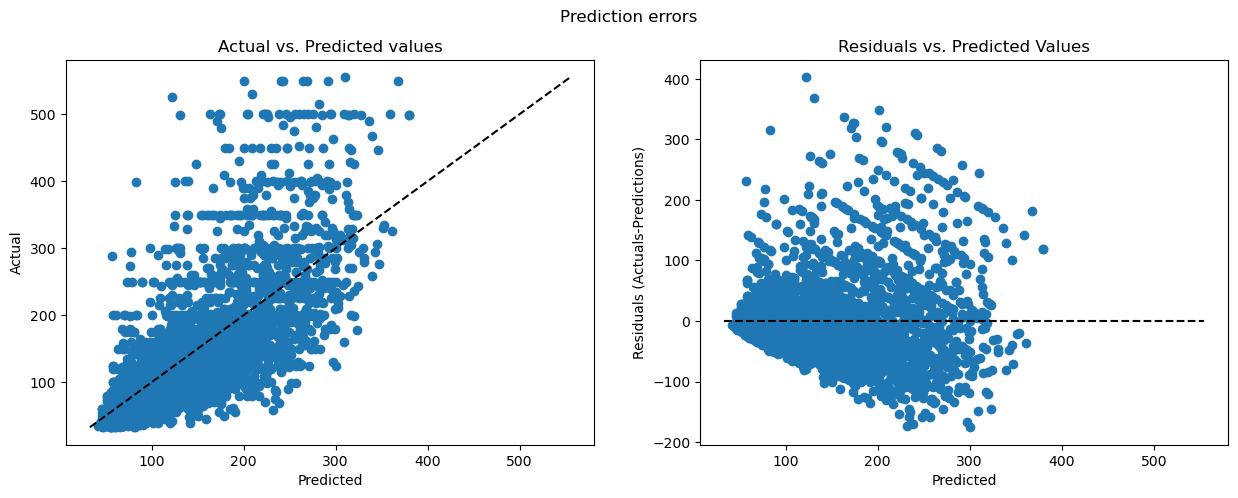

R²: 0.5627451113355987
MAE: 41.07743077885374
MSE: 3911.796940594226
RMSE: 62.54435978243143
MAPE: 0.32214093099511787
error_ratio_rmse: 0.4522058849259789
error_ratio_mae: 0.2969964997715909


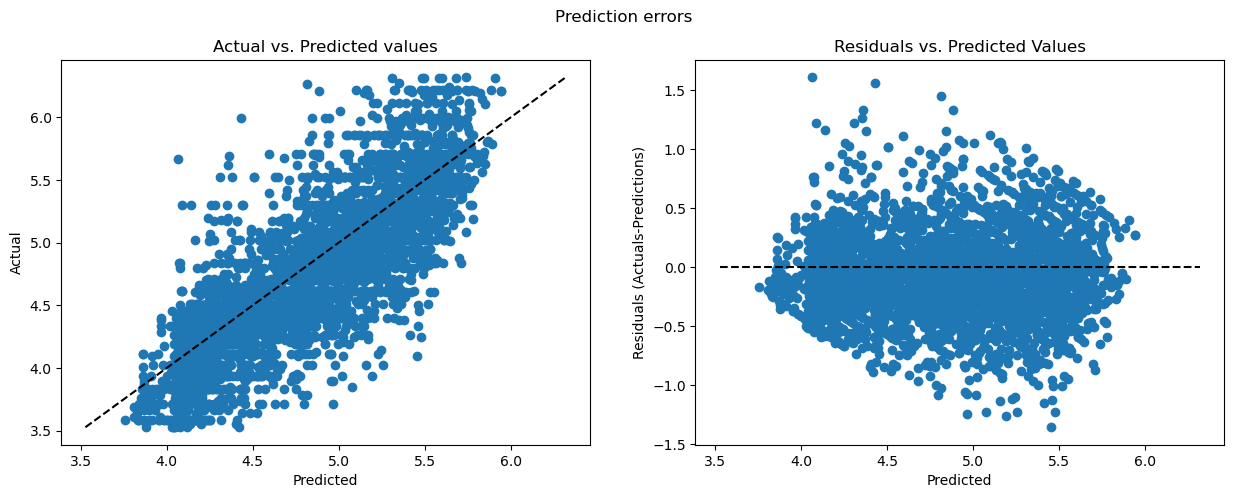

R²: 0.6508172077707954
MAE: 0.28740053403773563
MSE: 0.13570304038499317
RMSE: 0.36837893585952114
MAPE: 0.06195397494019402
error_ratio_rmse: 0.07774779442716816
error_ratio_mae: 0.06065699057001794


In [10]:
model_tuned = RandomForestRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          min_samples_leaf = int(best_hyperparams['min_samples_leaf']),
                          min_samples_split = int(best_hyperparams['min_samples_split']),
                          max_features=best_hyperparams['max_features'],
                          min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                          random_state = int(best_hyperparams['random_state']),
                          criterion = 'squared_error',
                          oob_score = True
                       )

model_tuned.fit(X_train_np, y_train_np)

y_pred = np.maximum(0,model_tuned.predict(X_test_np))
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

# Save Model

In [11]:
rf_params = model_tuned.get_params()

# Save the parameters as a JSON file
with open('saved_models/random_forest_params.json', 'w') as f:
    json.dump(rf_params, f)
